<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 5: Prediction of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

## Check PyCaret Version

In [1]:
from pycaret.utils import version
version()

'2.3.6'

#### Libraries

In [2]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [3]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

###### Declare some global variables

In [4]:
#Input Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final'
#dir_name = r'C:\Users\quant\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#dfblind = pd.read_excel("BlindTest_SSOIL_NEW.xlsx", sheet_name='Inputs', thousands=',', skiprows = skiprows)
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind_ori = dfblind.copy()
#dfblind.drop('307_Recovery factor (ultimate oil) (%)', axis=1, inplace=True)
#dfblind.dropna(axis = 0, inplace=True)

dfblind.head(10)

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,20.0000,8.6,12.0,30.0,32.0,1.100,118,1200.0,17.0,...,1,0,0,2407,151,1,10,1,2,0.274000
1,1,10.0000,10.0,60.0,25.0,40.0,1.100,110,1500.0,34.0,...,0,1,0,2407,151,1,10,1,1,0.360000
2,1,20.0000,11.0,110.0,28.0,25.0,1.060,125,1500.0,20.0,...,0,1,1,2407,151,1,10,1,2,0.320000
3,1,10.0000,190.0,480.0,27.0,22.0,1.140,146,430.0,23.5,...,0,0,0,418,181,1,10,1,2,0.258000
4,1,2.3662,556.0,1500.0,25.5,20.0,1.311,190,58.0,27.7,...,0,1,0,414,181,1,30,3,2,0.309771
5,1,5.0000,295.0,350.0,29.0,21.0,1.050,135,842.0,18.4,...,1,1,0,416,181,1,10,1,3,0.335160
6,1,10.0000,45.0,250.0,32.0,30.0,1.050,130,350.0,17.0,...,1,1,0,423,172,1,10,1,2,0.410000
7,1,72.0000,95.0,114.0,36.0,40.0,1.080,105,137.0,22.9,...,1,1,0,415,181,1,10,1,2,0.081141
8,2,12.0000,325.0,500.0,22.0,25.0,1.200,193,26816.5,21.5,...,0,1,1,414,181,1,10,1,3,0.436908
9,1,2.5000,300.0,1000.0,23.0,40.0,1.150,190,60.0,27.0,...,1,1,0,415,181,1,30,3,2,0.350000


## Load the Model

In [6]:
from pycaret.regression import load_model
from pycaret.regression import predict_model

from functools import reduce

final_ET = load_model('Bagged_ET_15072022')
final_gbr = load_model('Bagged_GradBoost_15072022')
final_blend = load_model('Blended_model_15072022')
final_stack = load_model('Stack_10_15072022')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [7]:
print(final_blend)

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='regression', target='URF')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    target='URF...
                                              ExtraTreesRegressor(criterion='mae',
                                                                  max_depth=9,
                                                                  max_features='sqrt',
                                                

In [8]:
BlindPredict1 = predict_model(final_ET, data=dfblind, round=2)
BlindPredict2 = predict_model(final_gbr, data=dfblind, round=2)
BlindPredict3 = predict_model(final_blend, data=dfblind, round=2)
BlindPredict4 = predict_model(final_stack, data=dfblind, round=2)

BlindPredict1 = BlindPredict1.rename(columns={'Label': 'Extra Tree Regressor URF (V/V)'
                                 })
BlindPredict2 = BlindPredict2.rename(columns={'Label': 'Gradient Boost URF (V/V)'
                                 })
BlindPredict3 = BlindPredict3.rename(columns={'Label': 'Blended URF (V/V)'
                                 })
BlindPredict4 = BlindPredict4.rename(columns={'Label': 'Stacked (V/V)'
                                 })

BlindPredict_df = [BlindPredict1, BlindPredict2, BlindPredict3, BlindPredict4]

BlindPredict = pd.concat(BlindPredict_df, axis = 0, join = 'outer').drop_duplicates()
BlindPredict = BlindPredict.reset_index(drop=True)

BlindPredict

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Initial GOR,Pressure Initial,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF,Extra Tree Regressor URF (V/V),Gradient Boost URF (V/V),Blended URF (V/V),Stacked (V/V)
0,1,20.00000,8.6,12.00,30.00,32.0,1.10000,118,1200.0000,17.00,160.000000,23400000,172.6380,1200.000000,1,0,0,2407,151,1,10,1,2,0.274000,0.385423,NaN,NaN,NaN
1,1,10.00000,10.0,60.00,25.00,40.0,1.10000,110,1500.0000,34.00,7.600000,45173000,248.2460,1000.000000,0,1,0,2407,151,1,10,1,1,0.360000,0.393650,NaN,NaN,NaN
2,1,20.00000,11.0,110.00,28.00,25.0,1.06000,125,1500.0000,20.00,71.200000,210000000,229.3440,1400.000000,0,1,1,2407,151,1,10,1,2,0.320000,0.399137,NaN,NaN,NaN
3,1,10.00000,190.0,480.00,27.00,22.0,1.14000,146,430.0000,23.50,4.500000,50460000,432.0000,1795.000000,0,0,0,418,181,1,10,1,2,0.258000,0.364319,NaN,NaN,NaN
4,1,2.36620,556.0,1500.00,25.50,20.0,1.31100,190,58.0000,27.70,2.656040,223000000,40.0000,2900.000000,0,1,0,414,181,1,30,3,2,0.309771,0.362766,NaN,NaN,NaN
5,1,5.00000,295.0,350.00,29.00,21.0,1.05000,135,842.0000,18.40,40.000000,1095000000,212.6660,1771.971881,1,1,0,416,181,1,10,1,3,0.335160,0.334630,NaN,NaN,NaN
6,1,10.00000,45.0,250.00,32.00,30.0,1.05000,130,350.0000,17.00,175.000000,216696000,154.5700,1100.000000,1,1,0,423,172,1,10,1,2,0.410000,0.340496,NaN,NaN,NaN
7,1,72.00000,95.0,114.00,36.00,40.0,1.08000,105,137.0000,22.90,11.155800,21226000,160.0000,800.000000,1,1,0,415,181,1,10,1,2,0.081141,0.335536,NaN,NaN,NaN
8,2,12.00000,325.0,500.00,22.00,25.0,1.20000,193,26816.5000,21.50,5.000000,31700000,500.0000,3000.000000,0,1,1,414,181,1,10,1,3,0.436908,0.377227,NaN,NaN,NaN
9,1,2.50000,300.0,1000.00,23.00,40.0,1.15000,190,60.0000,27.00,2.000000,315000000,150.0000,1800.000000,1,1,0,415,181,1,30,3,2,0.350000,0.349100,NaN,NaN,NaN


In [9]:
aggregation_functions = {
    'Extra Tree Regressor URF (V/V)': 'sum', 
    'Gradient Boost URF (V/V)': 'sum',
    'Blended URF (V/V)': 'sum',
    'Stacked (V/V)': 'sum',
}

labels = dfblind.columns.tolist()

BlindPredict_new = BlindPredict.groupby(labels).aggregate(aggregation_functions)

file_out(BlindPredict, dir_name, 'Blind_Test_Out' , filename_suffix)

BlindPredict_new

Final File Extract Produced


Extra Tree Regressor URF (V/V)  \
Lithology Code Well Spacing Net Pay Pay Gross Pay Porosity Swi  Oil FVFi Temp Permeability API Gravity Viscosity   OOIP       Initial GOR Pressure Initial Fractured Faulted Shale Breaks Major Gas Cap Geologic Play Deposition System Diagenetic Overprint Structural Comp Heterogeniety Trap Type URF                                        
1              1.00000      325.0       415.00    25.00    37.0 1.00000  85   600.0000     12.00       6400.000000 72000000   40.0000     208.200000       0                 0            1             415           181               1                    10              1             3         0.444445                        0.329195   
               2.00000      57.0        80.00     20.00    46.6 1.26000  120  280.0000     39.60       1.100000    24350800   600.0000    1925.000000      1                 0            0             2412          152               1                    10              1             2         0.614000                        0.390833   
               2.36620      556.0       1500.00   25.50    20.0 1.31100  190  58.0000      27.70       2.656040    223000000  40.0000     2900.000000      0                 1            0             414           181               1                    30              3             2         0.309771                        0.362766   
               2.42202      20.0        30.00     19.00    25.0 1.05000  68   650.0000     33.00       11.000000   58400000   100.0000    600.000000       0                 1            0             910           132               1                    10              1             3         0.316000                        0.366554   
               2.50000      206.0       1000.00   36.00    34.0 1.03000  100  1000.0000    15.50       750.000000  141000000  50.0000     700.000000       1                 1            0             416           181               1                    30              3             3         0.690000                        0.316192   
                            300.0       1000.00   23.00    40.0 1.15000  190  60.0000      27.00       2.000000    315000000  150.0000    1800.000000      1                 1            0             415           181               1                    30              3             2         0.350000                        0.349100   
                            325.0       800.00    26.00    30.0 1.15000  155  250.0000     28.00       4.000000    457000000  200.0000    1475.000000      1                 1            0             415           181               1                    30              3             2         0.400000                        0.359182   
                            750.0       1200.00   23.00    35.0 1.36000  170  90.0000      24.00       2.000000    185000000  320.0000    2800.000000      1                 1            1             414           181               1                    10              1             2         0.350000                        0.360809   
               3.00000      300.0       450.00    33.00    40.0 1.05000  100  2500.0000    15.90       1440.000000 314000000  200.0000    600.000000       1                 1            0             418           160               1                    10              1             2         0.140000                        0.299250   
               5.00000      295.0       350.00    29.00    21.0 1.05000  135  842.0000     18.40       40.000000   1095000000 212.6660    1771.971881      1                 1            0             416           181               1                    10              1             3         0.335160                        0.334630   
                            392.0       1200.00   35.00    25.0 1.05000  118  600.0000     19.20       25.000000   634840000  85.0000     1000.000000      1                 1            0             412           181               1                    30    

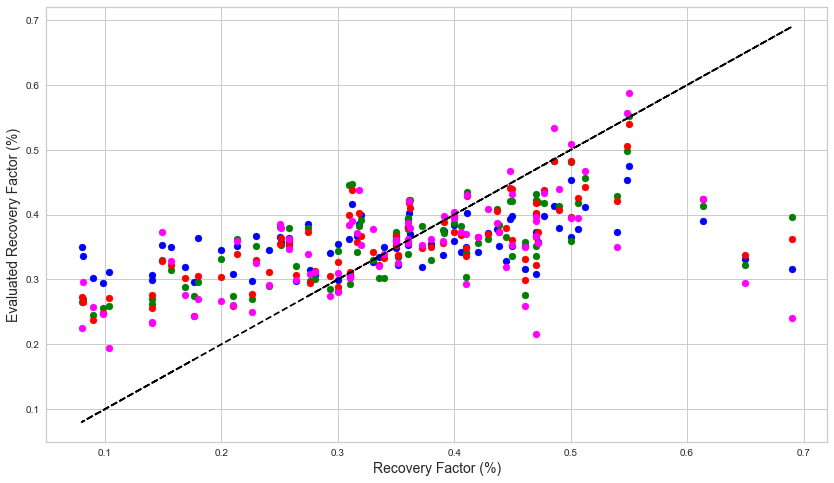

In [10]:
a = BlindPredict['URF']
b = BlindPredict['Extra Tree Regressor URF (V/V)']
c = BlindPredict['Gradient Boost URF (V/V)']
d = BlindPredict['Blended URF (V/V)']
e = BlindPredict['Stacked (V/V)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.scatter(a, d, color='red')
plt.scatter(a, e, color='magenta')
plt.plot(a, a, color = 'black', ls = '--', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [11]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 5.027841329574585 seconds
